<p style="background:#4c8527; color:white; font-size: 2.1em; text-align:center"> 
    <br><b> European Football Database</b><br><br>
    - Model of Matches Outcome -<br><br>
</p>

<p style="text-align: right;">Module 2: Data Analysis<br>
Sprint 4: Capstone Project<br>
Author : Renato Mariano</p>

This notebook is the continuation of the EDA performed in "01_Soccer_EDA". Please refer to this file.

Here we start directly by loading the necessary libraries and data.

<h1 style="color:#4C8527">Library Imports and Data Loading</h1>

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xmltodict

from suplement_functions import (select_all_columns, extract_goal_summary, clear_barplot, get_season)

In [2]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

In [3]:
# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)       # control the amount of output digits

from IPython.core.display import HTML                             # center plots in the notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
# Connect to the SQLite database
con = sqlite3.connect("data/soccer_data.sqlite")

# checking the database tables
table = pd.read_sql(select_all_columns("sqlite_master WHERE type='table'"), con)
sqlite_sequence = pd.read_sql(select_all_columns("sqlite_sequence"), con)

# Passes all the tables to a dictionary
soccer_dict = {}

for name in sqlite_sequence["name"]:
    soccer_dict[name] = pd.read_sql(select_all_columns(name), con)
soccer_dict.keys()

dict_keys(['Team', 'Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team_Attributes'])

<h1 style="color:#4C8527;">Data Preparation and Feature Engineering</h1>

This section was used to perform the Data cleaning from the previous notebook, to create some new features for the model and to prepare the data for being applied in the model.

<h2 style="color:#4C8527;">On Team Attributes</h2>

We started by finding out the season for the measurements and by dropping the 1 single duplicated value.

In [5]:
# Find the season for each row
soccer_dict['Team_Attributes']['date'] = pd.to_datetime(soccer_dict['Team_Attributes']['date'])
soccer_dict['Team_Attributes']['Season'] = soccer_dict['Team_Attributes']['date'].apply(get_season)

# Drop this single duplicated value.
soccer_dict['Team_Attributes'].drop_duplicates(subset=['team_api_id', 'Season'], inplace=True)
soccer_dict['Team_Attributes'].shape

(1457, 26)

We will keep only the attributes column and drop the "buildUpPlayDribbling" since 66% of the data is Null.

In [6]:
# Selected columns for Team Att
selected_columns_team = soccer_dict["Team_Attributes"].select_dtypes(include=["int64", "float64"]).columns.tolist()
selected_columns_team.append("Season")

# Create the condensed df - drop buildUpPlayDribbling 66% NA
team_att_condensed = soccer_dict["Team_Attributes"][selected_columns_team].drop(
    ["id", "team_fifa_api_id", "buildUpPlayDribbling"], axis=1
)
team_att_condensed.head(3)

,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,Season
0,9930,60,50,60,65,55,50,55,45,2009/2010
1,9930,52,56,54,63,64,47,44,54,2014/2015
2,9930,47,54,54,63,64,47,44,54,2015/2016


An **average for all of the attack attributes was computed and the same was performed to the deffence**. These columns will be used further in the modelling section. All of the other attributes will be dropped.

As a simplification for our data preparation, we will keep only the median rating (atk/def) of each team throughout all the seasons.

In [7]:
# Compute an average value for attack and deffense of each team
team_att_condensed["attack_attr"] = team_att_condensed.iloc[:,1:6].mean(axis=1)
team_att_condensed["deffense_attr"] = team_att_condensed.iloc[:,6:9].mean(axis=1)

# Keep only the to be used columns
team_att_condensed = team_att_condensed[["team_api_id", "attack_attr", "deffense_attr"]]

# Calculate the median throughout the all the seasons
team_att_condensed = team_att_condensed.groupby("team_api_id").agg("median").reset_index()
team_att_condensed.head(3)

,team_api_id,attack_attr,deffense_attr
0,1601,53.400,45.333
1,1773,51.800,45.667
2,1957,49.200,50.500


<h2 style="color:#4C8527;">On Player Attributes</h2>

We start by finding the season and keeping the median value for a player attribute in 1 season. 

The categorical data was dropped in the process. The rows containing null values were not dropped (<2% of the data).

The remaining dataframe has 37% of the original rows.

In [8]:
# Find the season for each player attribute
soccer_dict['Player_Attributes']['date'] = pd.to_datetime(soccer_dict['Player_Attributes']['date'])
soccer_dict['Player_Attributes']['Season'] = soccer_dict['Player_Attributes']['date'].apply(get_season)

# Condensed player's attributes dataframe
player_att_condensed = soccer_dict["Player_Attributes"].groupby(['player_api_id', 'Season']).agg("median").reset_index()
player_att_condensed.head(3)

,player_api_id,Season,id,player_fifa_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2625,2006/2007,139857.000,148544.000,63.000,64.000,48.000,48.000,47.000,64.000,...,56.000,46.000,64.000,66.000,63.000,14.000,11.000,67.000,9.000,10.000
1,2625,2007/2008,139856.000,148544.000,63.000,64.000,48.000,48.000,47.000,64.000,...,56.000,46.000,64.000,66.000,63.000,14.000,24.000,67.000,24.000,24.000
2,2625,2008/2009,139855.000,148544.000,60.000,64.000,48.000,48.000,47.000,64.000,...,56.000,46.000,64.000,66.000,63.000,14.000,24.000,67.000,24.000,24.000


In [9]:
player_att_condensed.shape

(70215, 39)

As explained before, most of the features are to some extent correlated and Goalkeeper (gk) features tend to be inversely related to the features of field players. 

We will create 2 columns, one for an average gk attribute and another rating excluding the gk columns.

In the process, some of the null values contained in the dataframe were ignored for the calculation of the mean. This can generate uncertainty to the model. 

In [10]:
player_att_condensed['rating_field_players'] = player_att_condensed.iloc[:,6:34].mean(axis=1)
player_att_condensed['rating_gk'] = player_att_condensed.iloc[:,34:39].mean(axis=1)

player_att_condensed.loc[:,["player_api_id", "overall_rating", "rating_field_players", 'rating_gk']].head(2)

,player_api_id,overall_rating,rating_field_players,rating_gk
0,2625,63.000,57.036,22.200
1,2625,63.000,57.214,30.600


Inversely to what was expected, the overrall rating of field players decreased in relation to the overrall rating.

Let's keep only the columns to be used in the model.

As a simplification for our data preparation, we will use only the median rating of each player.

In [11]:
player_att_condensed = player_att_condensed[["player_api_id", "rating_field_players", "rating_gk"]]
player_att_condensed = player_att_condensed.groupby("player_api_id").agg("median").reset_index()
player_att_condensed.head(5)

,player_api_id,rating_field_players,rating_gk
0,2625,57.893,9.000
1,2752,51.411,9.600
2,2768,54.571,11.800
3,2770,61.018,18.500
4,2790,62.286,28.400


<h2 style="color:#4C8527;">On Matches</h2>

In the Exploratory Data Analysis, 4 columns were added to the 'Match' df, 2 coming from the column 'goal', and 2 relative to the home and away goals.

In [12]:
# Find the number of goals per match
soccer_dict["Match"]["Nr_goals"] = (
    soccer_dict["Match"]["home_team_goal"] + soccer_dict["Match"]["away_team_goal"]
)

# Create a column to store who won the match
soccer_dict["Match"]["win"] = pd.np.where(
    soccer_dict["Match"]["home_team_goal"] > soccer_dict["Match"]["away_team_goal"],
    "Home Team Win",
    pd.np.where(
        soccer_dict["Match"]["home_team_goal"] < soccer_dict["Match"]["away_team_goal"],
        "Away Team Win",
        "Tie",
    ),
)

<h2 style="color:#4C8527;">Merged Dataframe</h2>

<h3 style="color:#4C8527;">Player Attributes</h3>

For each match **we will compute an average team rating from the players attributes**. In order to do that let's first get only rows with valid home and away players_id and check if all of these players have valid attributes.

In [13]:
# Matches with all players id
matches = soccer_dict["Match"][~soccer_dict["Match"].iloc[:,55:77].isna().any(axis=1)]

# Find the unique
unique_players_in_matches =  pd.Series(matches.iloc[:,55:77].values.flatten()).unique()

# Verify if all the players in matches are encompassed in players_attributes
missing_player_ids = set(unique_players_in_matches) - set(player_att_condensed["player_api_id"].unique())
print(missing_player_ids)

set()


As verified, **all the players in matches have valid attributes** and the overall players rating can be computed. 

**The overall rating of a team will be composed of the individual players rating. The rating for player_1 will come from the goalkeeper column.**

In [14]:
def get_players_ratings(matches_df, player_ratings, gk_ratings):
    ''' Function to get a list with all the player ratings and to compute the overall players rating'''

    players_ratings_list = []
    players_ratings_avg = []

    for index, row in matches_df.iterrows():
        ratings = [gk_ratings[row[0]]] + [
            player_ratings[player_id] for player_id in row[1:]
        ]
        players_ratings_list.append(ratings)
        players_ratings_avg.append(np.average(ratings))

    return players_ratings_list, players_ratings_avg

In [15]:
# Create a dictionary to map player_api_id to their mean ratings
player_ratings = pd.Series(
    player_att_condensed["rating_field_players"].values,
    index=player_att_condensed["player_api_id"],
).to_dict()

gk_ratings = pd.Series(
    player_att_condensed["rating_gk"].values,
    index=player_att_condensed["player_api_id"],
).to_dict()

# get home players ratings
players_ratings_list, players_ratings_avg = get_players_ratings(matches.iloc[:, 55:66], player_ratings, gk_ratings)
matches["home_players_ratings_list"] = players_ratings_list
matches["home_players_ratings"] = players_ratings_avg

# get away players ratings
players_ratings_list, players_ratings_avg = get_players_ratings(matches.iloc[:, 66:77], player_ratings, gk_ratings)
matches["away_players_ratings_list"] = players_ratings_list
matches["away_players_ratings"] = players_ratings_avg

In [16]:
matches.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBA,BSH,BSD,BSA,Nr_goals,win,home_players_ratings_list,home_players_ratings,away_players_ratings_list,away_players_ratings
145,146,1,1,2008/2009,24,2009-02-27 00:00:00,493017,8203,9987,2,...,2.300,2.800,3.200,2.250,3,Home Team Win,"[63.0, 52.75, 67.88392857142857, 53.2142857142...",59.418,"[63.8, 64.25, 58.607142857142854, 61.857142857...",62.509
153,154,1,1,2008/2009,25,2009-03-08 00:00:00,493025,9984,8342,1,...,2.300,2.620,3.200,2.380,4,Away Team Win,"[65.4, 57.785714285714285, 55.57142857142857, ...",61.785,"[70.2, 63.82142857142857, 57.23214285714286, 6...",64.114
155,156,1,1,2008/2009,25,2009-03-07 00:00:00,493027,8635,10000,2,...,8.500,1.360,4.200,7.000,2,Home Team Win,"[68.4, 60.59821428571429, 58.30357142857143, 5...",64.402,"[66.95, 57.48214285714286, 56.294642857142854,...",60.380


<h3 style="color:#4C8527;">Team Attributes</h3>

Before merging the team attributes, **let's select only the columns that will be used in the model** or that will still be needed in the merging process.

In [17]:
# Slice of the dataframe's columns
selected_columns_match = [3] + list(range(6,11)) + list(range(115,117)) + [118, 120]
matches_condensed = matches.iloc[:, selected_columns_match]
matches_condensed.head(3)

,season,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,Nr_goals,win,home_players_ratings,away_players_ratings
145,2008/2009,493017,8203,9987,2,1,3,Home Team Win,59.418,62.509
153,2008/2009,493025,9984,8342,1,3,4,Away Team Win,61.785,64.114
155,2008/2009,493027,8635,10000,2,0,2,Home Team Win,64.402,60.380


Before proceeding to merging the data, **let's verify first if all the teams in 'matches' have corresponding values in the attributes table**. If one of the teams don't have available attributes the match will be dropped.

In [18]:
# Find the unique Teams with attributes
teams_id = team_att_condensed["team_api_id"].unique()
print(f"{len(teams_id)} teams have available attributes")

# Find matches without attribute
matches_condensed[
    (~matches_condensed["home_team_api_id"].isin(teams_id))
    | (~matches_condensed["away_team_api_id"].isin(teams_id))
].shape[0]

288 teams have available attributes


128

**So 128 Matches from current data set present teams without attributes**. These values will be dropped. We checked besides if these values belongged only to 1 league, but that was not the case (5 leagues were in this situation).

Besides, we will **remove any outlier match with more than 6 goals**.

In [19]:
# removal of matches without team attributes
matches_condensed = matches_condensed[
    (matches_condensed["home_team_api_id"].isin(teams_id))
    & (matches_condensed["away_team_api_id"].isin(teams_id))
]

# Outliers removal
matches_condensed = matches_condensed[matches_condensed['Nr_goals'] <= 6]
matches_condensed.shape

(20777, 10)

**The merge will be performed based on the teams id**. 

In [20]:
# Merge relevant team attributes for each match based on the season
matches_model = pd.merge(
    matches_condensed,
    team_att_condensed,
    left_on=["home_team_api_id"],
    right_on=["team_api_id"],
    how="left",
).drop("team_api_id", axis=1).rename(
    {"attack_attr": "home_attack_attr", "deffense_attr": "home_deffense_attr"}, axis=1
)

matches_model = pd.merge(
    matches_model,
    team_att_condensed,
    left_on=["away_team_api_id"],
    right_on=["team_api_id"],
    how="left",
    #suffixes=("", "_away"),
).drop("team_api_id", axis=1).rename(
    {"attack_attr": "away_attack_attr", "deffense_attr": "away_deffense_attr"}, axis=1
)

# Drop unnecessary columns
matches_model.drop(["match_api_id", "home_team_api_id", "away_team_api_id"], axis=1, inplace=True)
matches_model.head(2)

,season,home_team_goal,away_team_goal,Nr_goals,win,home_players_ratings,away_players_ratings,home_attack_attr,home_deffense_attr,away_attack_attr,away_deffense_attr
0,2008/2009,2,1,3,Home Team Win,59.418,62.509,49.800,51.833,53.400,49.333
1,2008/2009,1,3,4,Away Team Win,61.785,64.114,50.800,56.000,48.200,52.667


<h1 style="color:#4c8527">Model of Winnings</h1>

We start by making a transformation at the win column:
- 1 home team win
- 0 draw
- -1 away team win

In [21]:
matches_model["win"].replace({"Home Team Win":"1", "Away Team Win":"-1", "Tie":"0"},inplace=True)
matches_model.head(2)

,season,home_team_goal,away_team_goal,Nr_goals,win,home_players_ratings,away_players_ratings,home_attack_attr,home_deffense_attr,away_attack_attr,away_deffense_attr
0,2008/2009,2,1,3,1,59.418,62.509,49.800,51.833,53.400,49.333
1,2008/2009,1,3,4,-1,61.785,64.114,50.800,56.000,48.200,52.667


We will separate the train/test set by season, let's see the amount of data for each.

In [22]:
(matches_model.groupby('season').size() / matches_model.groupby('season').size().sum()) * 100

season
2008/2009    8.336
2009/2010   11.604
2010/2011   12.610
2011/2012   13.005
2012/2013   13.496
2013/2014   13.067
2014/2015   14.030
2015/2016   13.852
dtype: float64

The two last seasons amount to about 28% of the data and will be used as test set. The previous seasons will be used for training the model.

In [23]:
# Split the data into training and testing sets
df_train = matches_model[
    ~(matches_model["season"] == "2015/2016")
    & ~(matches_model["season"] == "2014/2015")
].drop(columns=["season"])

df_test = matches_model[
    (matches_model["season"] == "2015/2016") | (matches_model["season"] == "2014/2015")
].drop(columns=["season"])

# Separate variable to predict and drop irrelevant features for the model
X_train = df_train.drop(columns=['home_team_goal', 'away_team_goal', 'Nr_goals', 'win'])
y_train = df_train['win']
X_test = df_test.drop(columns=['home_team_goal', 'away_team_goal', 'Nr_goals', 'win'])
y_test = df_test['win']

In [24]:
X_train.columns

Index(['home_players_ratings', 'away_players_ratings', 'home_attack_attr',
       'home_deffense_attr', 'away_attack_attr', 'away_deffense_attr'],
      dtype='object')

<h2 style="color:#4c8527">CatBoostClassifier</h2>

We will start by training a CatBoostClassifier. As all of the independent features rate between 0 and 100 no scaling will be necessary.

In [25]:
# Train the model
CBC_model = CatBoostClassifier(iterations=5000, learning_rate=0.55)
CBC_model.fit(X_train, y_train, verbose=2000)

0:	learn: 1.0196292	total: 131ms	remaining: 10m 56s
2000:	learn: 0.2598853	total: 13.4s	remaining: 20s
4000:	learn: 0.1180850	total: 29.8s	remaining: 7.44s
4999:	learn: 0.0879492	total: 37.5s	remaining: 0us


In [26]:
# Prediction of results
y_pred = CBC_model.predict(X_test)

#Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.41791817711030554
Classification Report:
               precision    recall  f1-score   support

          -1       0.39      0.36      0.37      1746
           0       0.26      0.23      0.24      1496
           1       0.51      0.57      0.54      2551

    accuracy                           0.42      5793
   macro avg       0.39      0.39      0.38      5793
weighted avg       0.41      0.42      0.41      5793



Our model predicted the right outcome 41.7% of the time.

Let's see these results in a confusion matrix for an easier understanding.

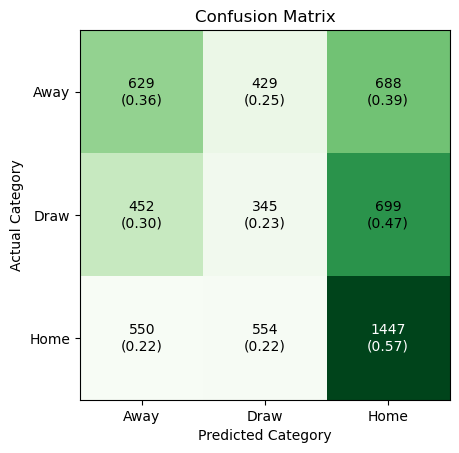

In [27]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                cmap='Greens')

plt.xticks(np.arange(3), ["Away", "Draw", "Home"])
plt.yticks(np.arange(3), ["Away", "Draw", "Home"])

ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Confusion Matrix",);

As we can see, the prediction power of the model is better for the winning of Home teams (57% true positives). About 39% of the predicted winnings for the away team belong actually to the home team.

The true positives for away amount to 36% and for Draw 23%.

Let's see the distribution of importance of the features for the model.

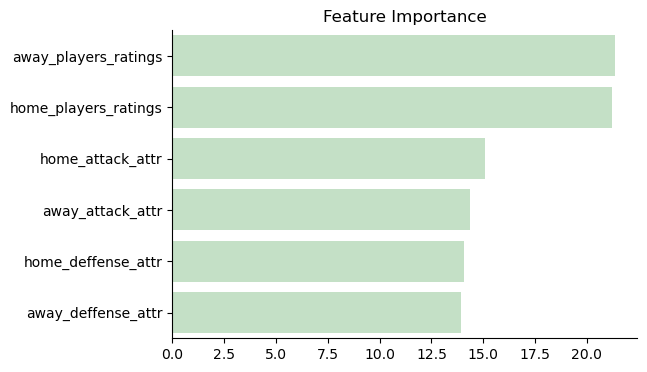

In [28]:
# Variable importances
feature_importance = pd.DataFrame({'variables':X_train.columns,
                                  'importance': CBC_model.feature_importances_}).sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=feature_importance, y= 'variables', x='importance', ax=ax, color="#a6d9aa", alpha=0.7)

sns.despine()
ax.set(
    ylabel="",
    xlabel="",
    title="Feature Importance",
)
ax.legend([], frameon=False);

Home attributes seem to be slightly more influencial to the model than the away ones, which makes sense according to the home advantage exposed in the previous notebook.

<h2 style="color:#4c8527">RandomForestClassifier</h2>

To further evaluate, we also tried to fit a Random Forest Classifier to the data.

In [29]:
# RandomForest
RFC_model = RandomForestClassifier()
RFC_model.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
# Prediction of results
y_pred = RFC_model.predict(X_test)

#Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.46003797686863457
Classification Report:
               precision    recall  f1-score   support

          -1       0.43      0.40      0.42      1746
           0       0.26      0.14      0.19      1496
           1       0.52      0.69      0.59      2551

    accuracy                           0.46      5793
   macro avg       0.41      0.41      0.40      5793
weighted avg       0.43      0.46      0.43      5793



This model returned a slightly better accuracy value (46.5%).

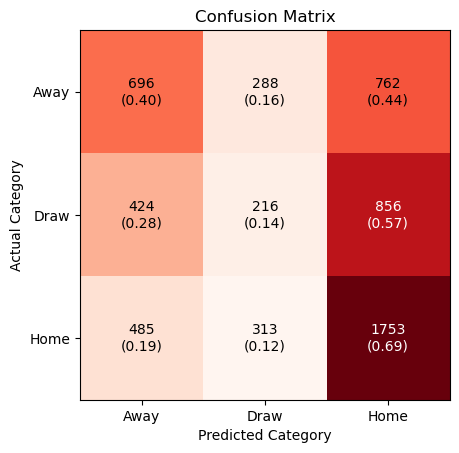

In [31]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                cmap='Reds')

plt.xticks(np.arange(3), ["Away", "Draw", "Home"])
plt.yticks(np.arange(3), ["Away", "Draw", "Home"])

ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Confusion Matrix",);

Again, the prediction power of the model is better for the winning of Home teams (70% true positives).

The true positives for away amount to 40% and for Draw 14%.

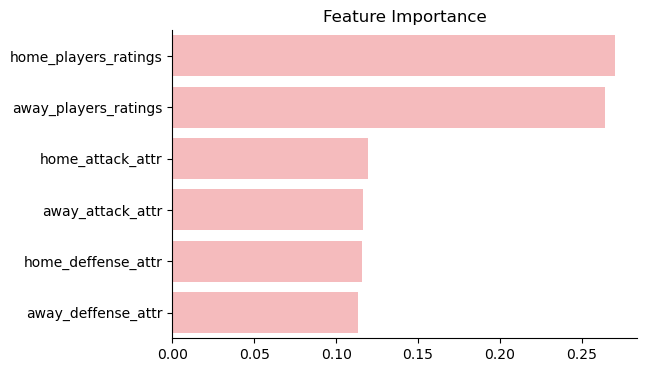

In [32]:
# Variable importances
feature_importance = pd.DataFrame({'variables':X_train.columns,
                                  'importance': RFC_model.feature_importances_}).sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=feature_importance, y= 'variables', x='importance', ax=ax, color="#ff9194", alpha=0.7)

sns.despine()
ax.set(
    ylabel="",
    xlabel="",
    title="Feature Importance",
)
ax.legend([], frameon=False);

The importance of the features changed only slightly, with home deffense surpassing the away attack.

<h1 style="color:#4c8527">Model of goals</h1>

We start our model by separating one dataframe for the home teams and another for the away teams. 

Besides, we create comparison attributes between, the home and away players, and between the teams' deffense and attack.

<h2 style="color:#4c8527">Home Team</h2>

In [33]:
home = matches_model[["season", "home_team_goal",]]
home["ratings_div"] = matches_model["home_players_ratings"] / matches_model["away_players_ratings"]
home["atk_def_div"] = matches_model["home_attack_attr"] / matches_model["away_deffense_attr"]

home.head(5)

,season,home_team_goal,ratings_div,atk_def_div
0,2008/2009,2,0.951,1.009
1,2008/2009,1,0.964,0.965
2,2008/2009,2,1.067,1.108
3,2008/2009,2,0.932,0.871
4,2008/2009,0,1.056,0.717


In [34]:
# Split the data into training and testing sets for 'home' dataframe
home_train = home[
    ~(matches_model["season"] == "2015/2016")
    & ~(matches_model["season"] == "2014/2015")
].drop(columns=["season"])

home_test = home[
    (matches_model["season"] == "2015/2016") | (matches_model["season"] == "2014/2015")
].drop(columns=["season"])

# Separate variable to predict and drop irrelevant features for the 'home' model
X_home_train = home_train.drop(columns=['home_team_goal'])
y_home_train = home_train['home_team_goal']
X_home_test = home_test.drop(columns=['home_team_goal'])
y_home_test = home_test['home_team_goal']

The prediction of the number of goals in a match is something very hard to achieve. Let's try to fit our data to some different types of models and check which one provide the best outcomes.

In [35]:
# Train a multinomial logistic regression model
multinomial_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
multinomial_model.fit(X_home_train, y_home_train)

# Make predictions on the testing data
y_home_pred = multinomial_model.predict(X_home_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_home_test, y_home_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.11      0.18      1384
           1       0.34      0.85      0.49      1899
           2       0.30      0.15      0.20      1416
           3       0.21      0.01      0.03       740
           4       0.50      0.00      0.01       245
           5       0.00      0.00      0.00        91
           6       0.00      0.00      0.00        18

    accuracy                           0.34      5793
   macro avg       0.26      0.16      0.13      5793
weighted avg       0.35      0.34      0.26      5793



Our model can predict the number of goals for the home team correctly about 34% of the time.

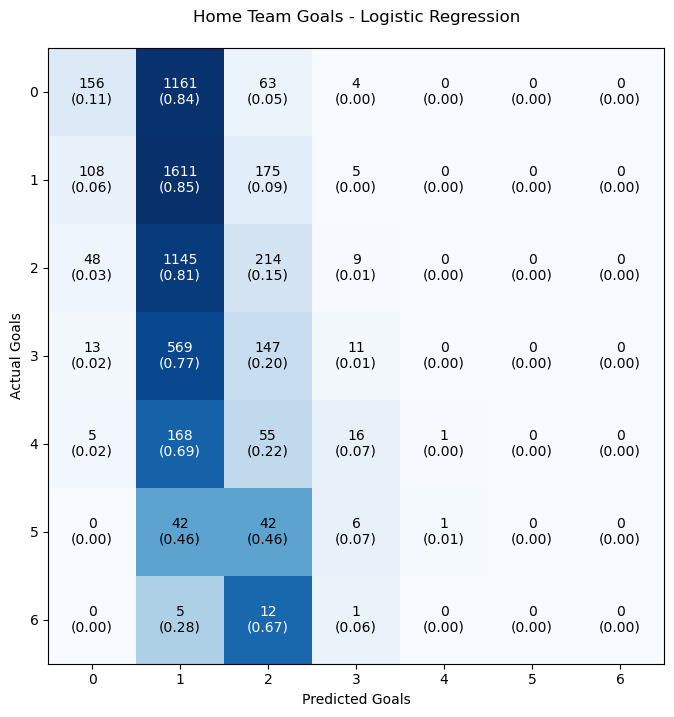

In [36]:
cm = confusion_matrix(y_home_test, y_home_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                cmap='Blues')

fig.set_figwidth(10)
fig.set_figheight(8)  
ax.set(ylabel="Actual Goals", xlabel="Predicted Goals", title="Home Team Goals - Logistic Regression\n",);

The true positives of out logistic model are only good for the quantity of 1 goals (85%). 

For 0 and 2 goals the true positives amount to 11% und 15% respectively. 

The other quantities of goals had a very low rate of true positives.

In [37]:
# RandomForest
RFC_model = RandomForestClassifier()
RFC_model.fit(X_home_train, y_home_train)

# Make predictions on the testing data
y_home_pred = RFC_model.predict(X_home_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_home_test, y_home_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.27      0.28      1384
           1       0.33      0.40      0.36      1899
           2       0.27      0.26      0.26      1416
           3       0.18      0.14      0.16       740
           4       0.11      0.08      0.09       245
           5       0.03      0.01      0.02        91
           6       0.00      0.00      0.00        18

    accuracy                           0.28      5793
   macro avg       0.17      0.17      0.17      5793
weighted avg       0.27      0.28      0.27      5793



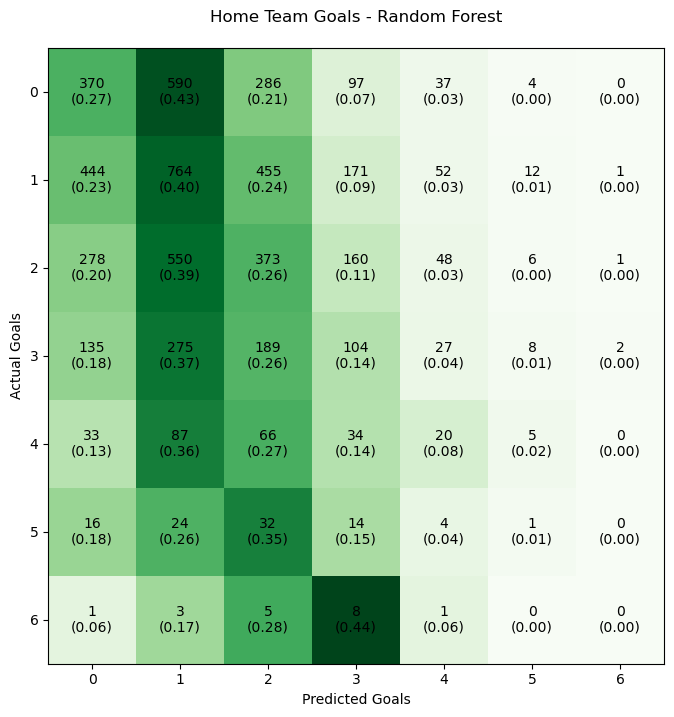

In [38]:
cm = confusion_matrix(y_home_test, y_home_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                cmap='Greens')

fig.set_figwidth(10)
fig.set_figheight(8)  
ax.set(ylabel="Actual Goals", xlabel="Predicted Goals", title="Home Team Goals - Random Forest\n",);

We see that for the Random Forest there are true positives being identified in more classes of goals, inspite the lower accuracy (28%).

<h2 style="color:#4c8527">Away Team</h2>

In [39]:
away = matches_model[["season", "away_team_goal"]]
away["ratings_div"] = matches_model["away_players_ratings"] / matches_model["home_players_ratings"]
away["atk_def_div"] = matches_model["away_attack_attr"] / matches_model["home_deffense_attr"]

# Split the data into training and testing sets for 'away' DataFrame
away_train = away[
    ~(matches_model["season"] == "2015/2016")
    & ~(matches_model["season"] == "2014/2015")
].drop(columns=["season"])

away_test = away[
    (matches_model["season"] == "2015/2016") | (matches_model["season"] == "2014/2015")
].drop(columns=["season"])

# Separate variable to predict and drop irrelevant features for the 'away' model
X_away_train = away_train.drop(columns=['away_team_goal'])
y_away_train = away_train['away_team_goal']
X_away_test = away_test.drop(columns=['away_team_goal'])
y_away_test = away_test['away_team_goal']

In [40]:
# Train a multinomial logistic regression model for the 'away' team
multinomial_model_away = LogisticRegression(multi_class='multinomial', solver='lbfgs')
multinomial_model_away.fit(X_away_train, y_away_train)

# Make predictions on the testing data
y_away_pred = multinomial_model_away.predict(X_away_test)

# Evaluate the 'away' model
print("Classification Report for Away Team:")
print(classification_report(y_away_test, y_away_pred))

Classification Report for Away Team:
              precision    recall  f1-score   support

           0       0.41      0.51      0.46      1914
           1       0.36      0.57      0.44      2038
           2       0.33      0.05      0.08      1156
           3       0.12      0.00      0.00       494
           4       0.00      0.00      0.00       152
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00         8

    accuracy                           0.38      5793
   macro avg       0.18      0.16      0.14      5793
weighted avg       0.34      0.38      0.32      5793



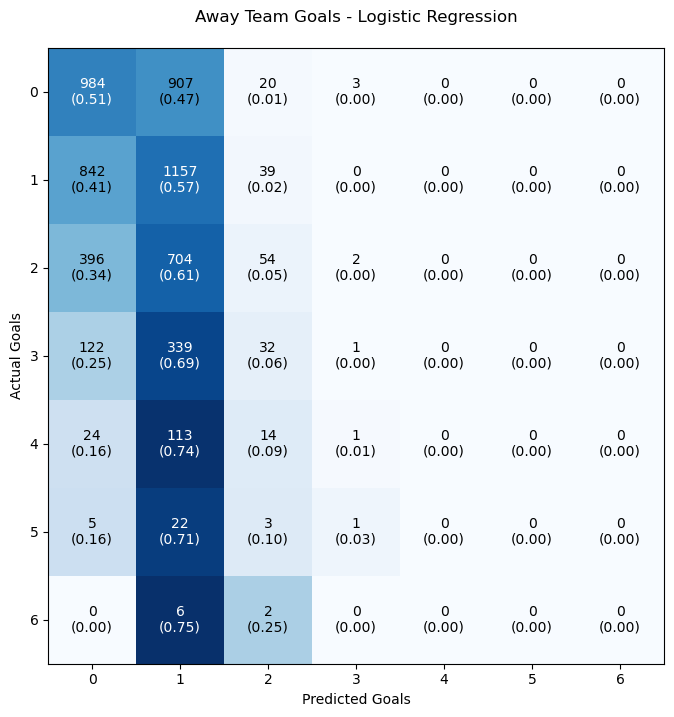

In [41]:
cm = confusion_matrix(y_away_test, y_away_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                cmap='Blues')

fig.set_figwidth(10)
fig.set_figheight(8)  
ax.set(ylabel="Actual Goals", xlabel="Predicted Goals", title="Away Team Goals - Logistic Regression\n",);

In [42]:
# RandomForest
RFC_model = RandomForestClassifier()
RFC_model.fit(X_away_train, y_away_train)

# Make predictions on the testing data
y_away_pred = RFC_model.predict(X_away_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_away_test, y_away_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.44      0.40      1914
           1       0.36      0.39      0.37      2038
           2       0.22      0.17      0.19      1156
           3       0.12      0.06      0.08       494
           4       0.04      0.02      0.03       152
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00         8

    accuracy                           0.32      5793
   macro avg       0.16      0.15      0.15      5793
weighted avg       0.30      0.32      0.31      5793



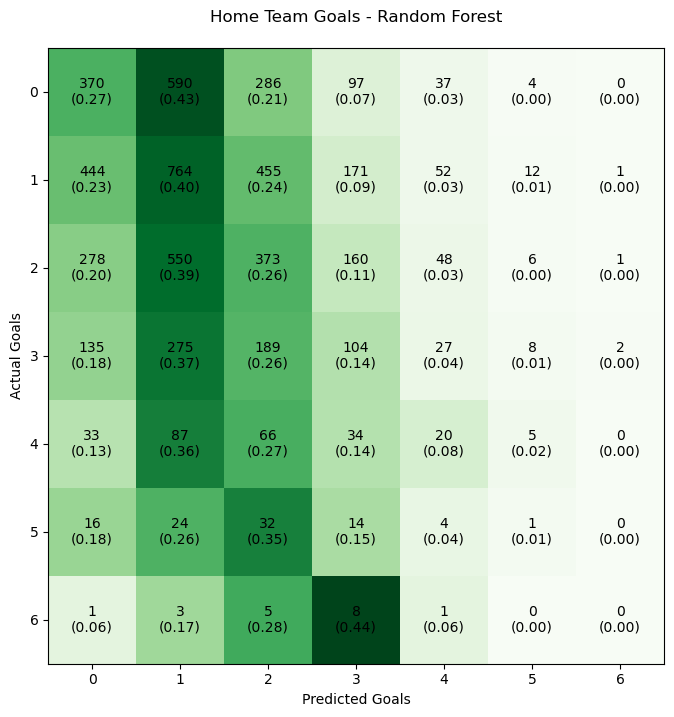

In [43]:
cm = confusion_matrix(y_home_test, y_home_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                cmap='Greens')

fig.set_figwidth(10)
fig.set_figheight(8)  
ax.set(ylabel="Actual Goals", xlabel="Predicted Goals", title="Home Team Goals - Random Forest\n",);

<h1 style="color:#4c8527">Conclusions (Model)</h1>

The **model of winnings** presented slightly better results with a RandomForestClassifier, it presented however a lesser prediction power for draws.
We can see that there is a tendency for this model to predict more values in the majoritary category.

In the case of the **model of goals** the **random forest presents** values that predict goals in more classes, which can be seem as good. But the overrall accuracy of the **Multinomial Logistic Regression** was better.

Improvements:
- Separate the attributes date by season.
- Test other types of models.
- Find ways to merge the goals model with the matches outcome.

Besides, for a complete evaluation of the goals model, a comparison must be carried out with the test x predicted from home and away goals together.
Based on the accuracy obtained in the previous models (of goals), I estimate that not more than 10% of the outcome of the matches could be properly estimated using these models (right number of goals home and away).